In [1]:
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms, models
from torchvision.models import MobileNet_V2_Weights, VGG16_Weights, ResNet18_Weights
from torch.utils.data import DataLoader, Subset
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cpu


In [3]:
def train_model(model, trainloader, valloader, criterion, optimizer, device=device, num_epochs=5):
    history = {
        'train_losses': [],
        'val_losses': [],
        'train_accuracies': [],
        'val_accuracies': []
    }

    for epoch in range(num_epochs):
        # Treinamento
        model.train()
        running_loss = 0.0
        correct = 0
        total = 0
        for i, data in tqdm(enumerate(trainloader, 0), total=len(trainloader)):
            inputs, labels = data
            inputs, labels = inputs.to(device), labels.to(device)

            optimizer.zero_grad()

            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

        train_loss = running_loss / len(trainloader)
        train_acc = 100 * correct / total
        history['train_losses'].append(train_loss)
        history['train_accuracies'].append(train_acc)
        print(f'Epoch {epoch+1}, Train Loss: {train_loss:.3f}, Train Accuracy: {train_acc:.2f}%')

        # Validação
        model.eval()
        val_running_loss = 0.0
        correct = 0
        total = 0
        with torch.no_grad():
            for data in valloader:
                inputs, labels = data
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                val_running_loss += loss.item()
                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()

        val_loss = val_running_loss / len(valloader)
        val_acc = 100 * correct / total
        history['val_losses'].append(val_loss)
        history['val_accuracies'].append(val_acc)
        print(f'Epoch {epoch+1}, Val Loss: {val_loss:.3f}, Val Accuracy: {val_acc:.2f}%')

    print('Treinamento concluído')
    return history


def plot_history(history):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))

    ax1.plot(history['train_losses'], label='Train')
    ax1.plot(history['val_losses'], label='Validation')
    ax1.set_title('Loss')
    ax1.legend()

    ax2.plot(history['train_accuracies'], label='Train')
    ax2.plot(history['val_accuracies'], label='Validation')
    ax2.set_title('Accuracy')
    ax2.legend()

    plt.show()


def test_model(model, testloader, device=device):
    correct = 0
    total = 0
    with torch.no_grad():
        for data in testloader:
            images, labels = data
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    print(f'Acurácia da rede na base de teste: {100 * correct / total:.2f}%')

In [4]:
# Baixa e extrai o dataset
!curl -L -o data/animais.zip "https://drive.google.com/uc?export=download&id=16Lll0Slg1unWxAb26AzZqI9sPdB_fYpV"
!unzip data/animais.zip -d data

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
  0     0    0     0    0     0      0      0 --:--:--  0:00:08 --:--:--     0Warning: Failed to create the file data/animais.zip: No such file or directory
  0 11.6M    0  1177    0     0    128      0 26:28:30  0:00:09 26:28:21   282
curl: (23) Failure writing output to destination
unzip:  cannot find or open data/animais.zip, data/animais.zip.zip or data/animais.zip.ZIP.


In [6]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [7]:
import os
data_dir = '/content/drive/MyDrive/Tópicos_Contemporâneos/animals'
os.listdir(data_dir)

['train', 'val']

In [8]:
# Carregando os datasets
transform_aug = transforms.Compose([
    transforms.RandomResizedCrop(224),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

transform_no_aug = transforms.Compose([
    transforms.Resize(230),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

train_set = datasets.ImageFolder(os.path.join(data_dir, 'train'), transform=transform_aug)
val_set = datasets.ImageFolder(os.path.join(data_dir, 'val'), transform=transform_no_aug)

train_loader = DataLoader(train_set, batch_size=32, shuffle=True)
val_loader = DataLoader(val_set, batch_size=32, shuffle=True)

In [9]:
model = models.resnet18(weights="IMAGENET1K_V1")

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 172MB/s]


In [10]:
# Congelar todas as camadas
for param in model.parameters():
    param.requires_grad = False

In [11]:
# Substituir a última camada
model.fc = nn.Linear(model.fc.in_features, 2)
model = model.to(device)

In [12]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

In [13]:
# Treinando a CNN
history = train_model(model, train_loader, val_loader, criterion, optimizer, device, num_epochs=5)

100%|██████████| 13/13 [01:56<00:00,  8.97s/it]


Epoch 1, Train Loss: 0.612, Train Accuracy: 67.75%


/usr/local/lib/python3.10/dist-packages/PIL/Image.py:996: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Epoch 1, Val Loss: 0.426, Val Accuracy: 85.25%


100%|██████████| 13/13 [00:42<00:00,  3.24s/it]


Epoch 2, Train Loss: 0.427, Train Accuracy: 83.00%
Epoch 2, Val Loss: 0.260, Val Accuracy: 93.44%


100%|██████████| 13/13 [00:41<00:00,  3.17s/it]


Epoch 3, Train Loss: 0.306, Train Accuracy: 89.00%
Epoch 3, Val Loss: 0.189, Val Accuracy: 93.44%


100%|██████████| 13/13 [00:41<00:00,  3.16s/it]


Epoch 4, Train Loss: 0.284, Train Accuracy: 88.50%
Epoch 4, Val Loss: 0.180, Val Accuracy: 95.08%


100%|██████████| 13/13 [00:40<00:00,  3.14s/it]


Epoch 5, Train Loss: 0.273, Train Accuracy: 89.25%
Epoch 5, Val Loss: 0.148, Val Accuracy: 93.44%
Treinamento concluído


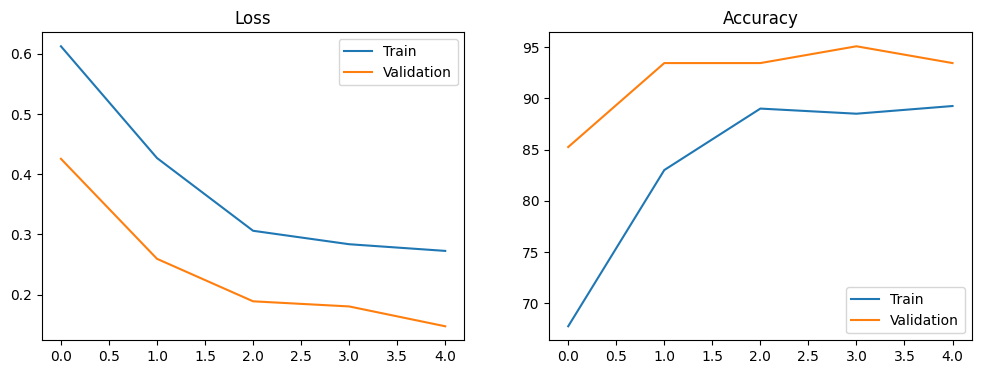

In [14]:
plot_history(history)

In [15]:
test_model(model, val_loader)

Acurácia da rede na base de teste: 93.44%


In [16]:
def plot_and_predict(model, image, class_names, device=device):
    model.eval()
    image = image.to(device)
    outputs = model(image.unsqueeze(0))
    _, predicted = torch.max(outputs.data, 1)
    probs = F.softmax(outputs, dim=1)[0] * 100
    prob = probs[predicted].item()

    # image between 0 and 1
    image = torch.clamp(image * 0.225 + 0.45, 0, 1)
    title = f'Classe: {class_names[predicted]} ({prob:.2f}%)'
    plt.imshow(image.permute(1, 2, 0).cpu().numpy())
    plt.title(title)
    plt.axis('off')
    plt.show()

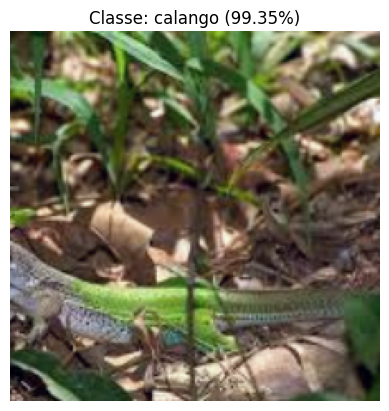

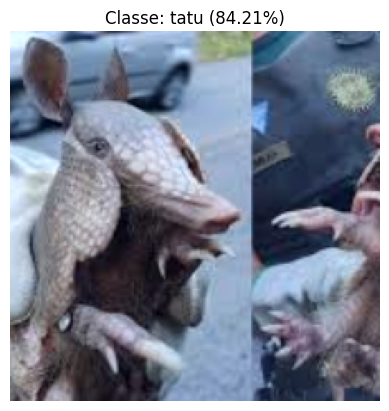

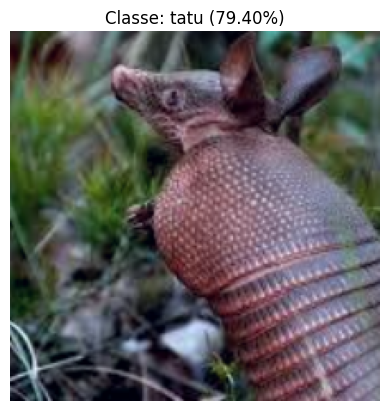

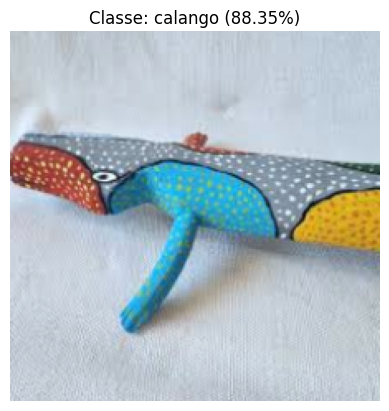

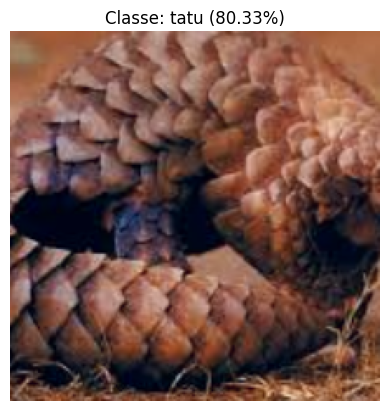

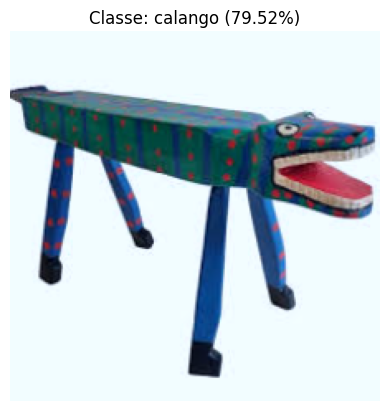

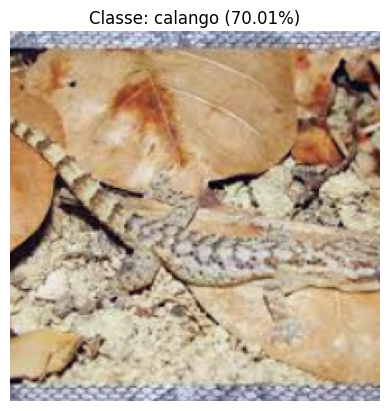

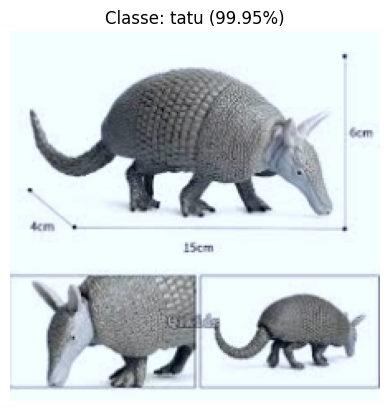

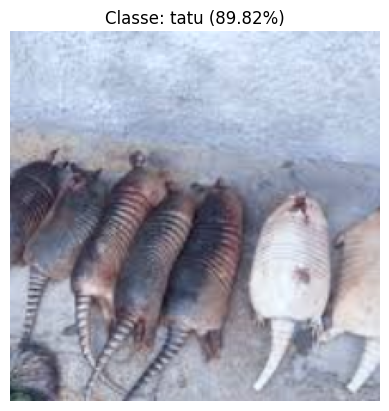

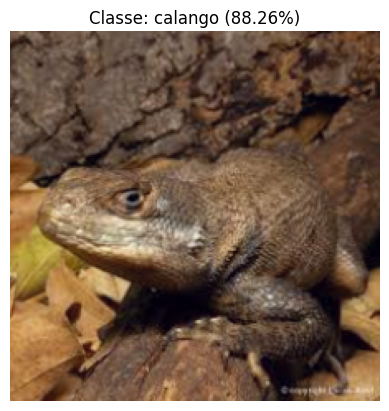

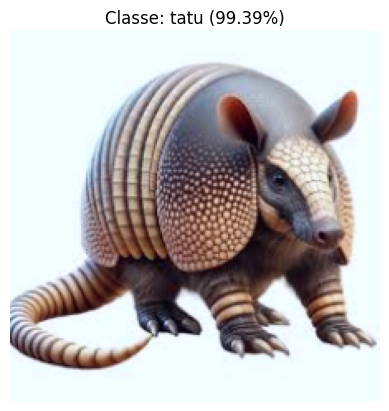

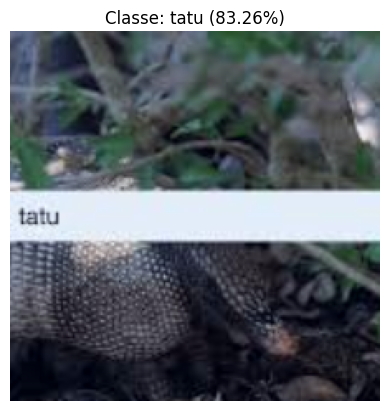

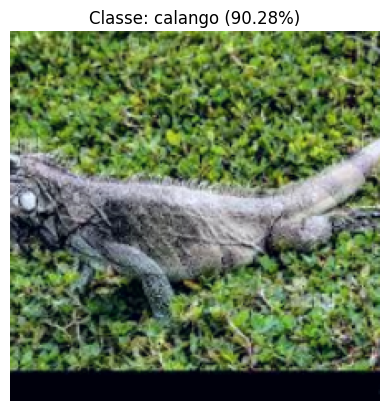

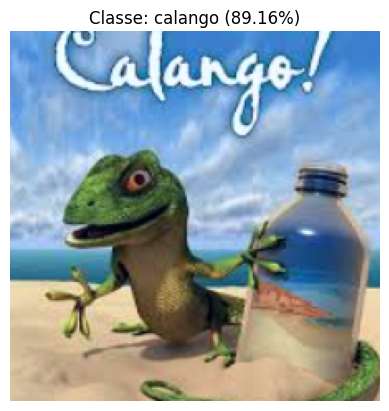

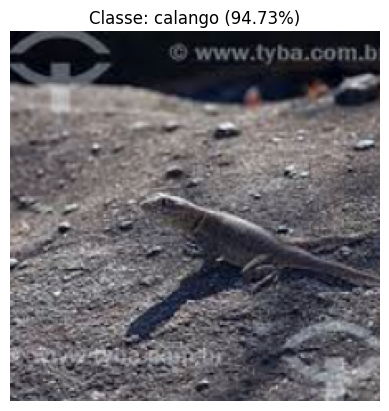

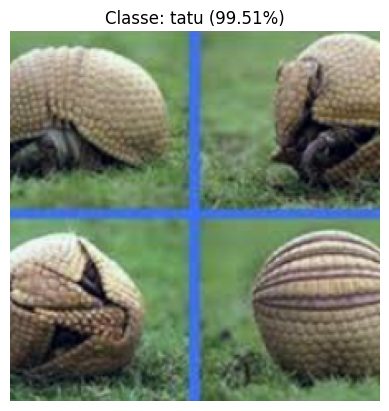

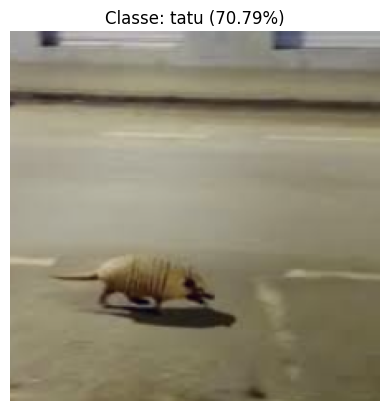

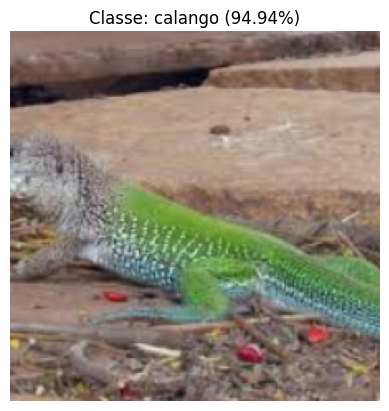

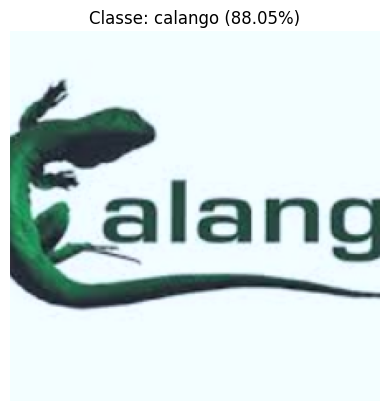

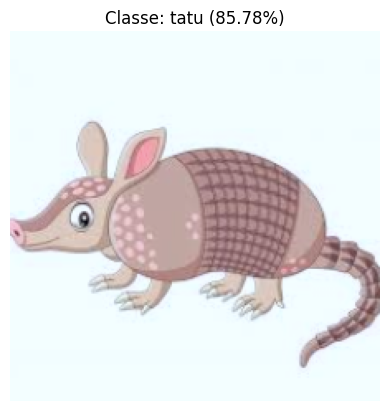

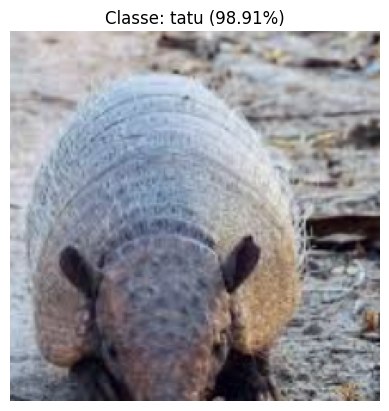

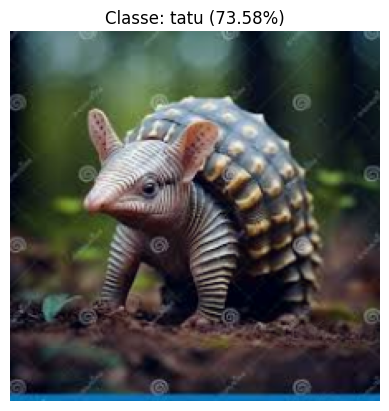

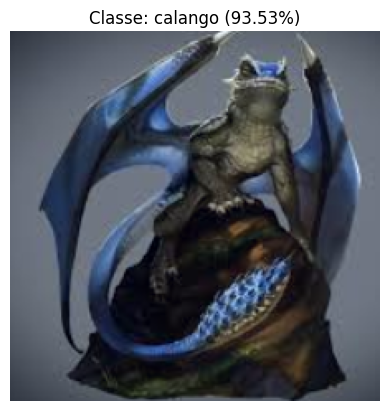

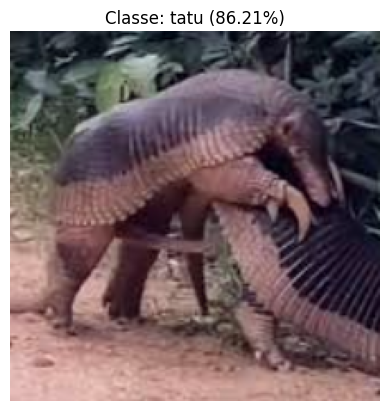

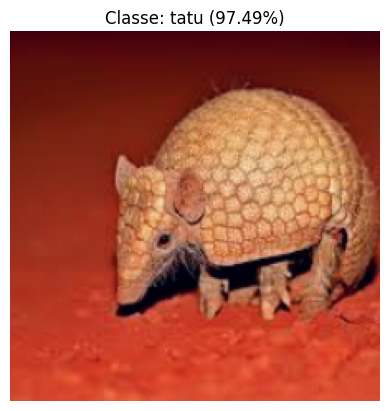

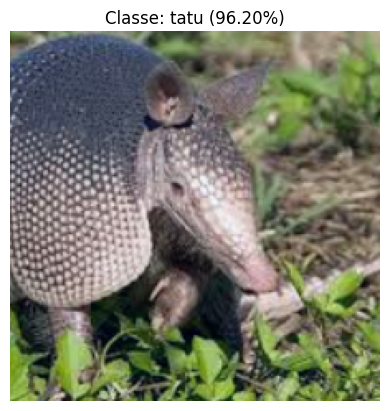

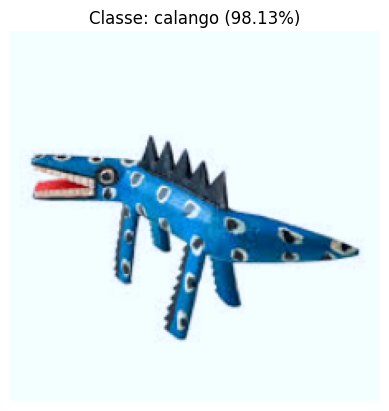

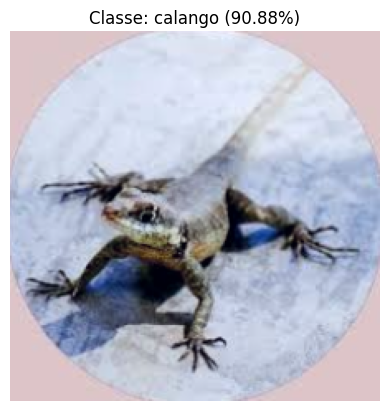

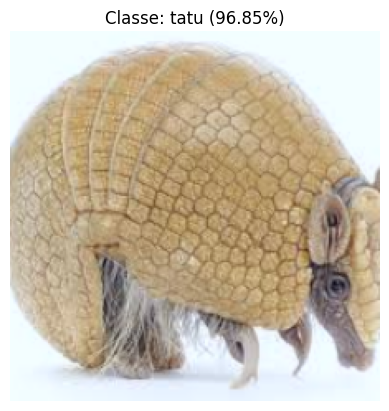

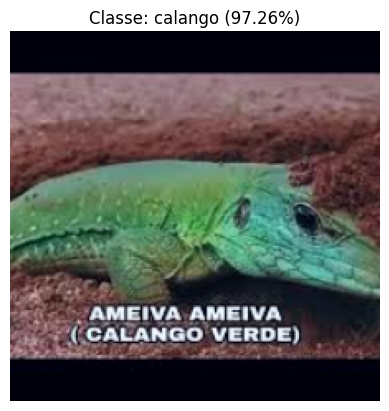

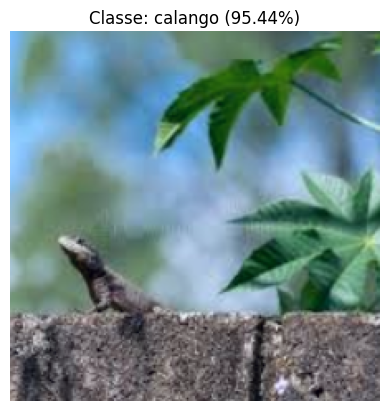

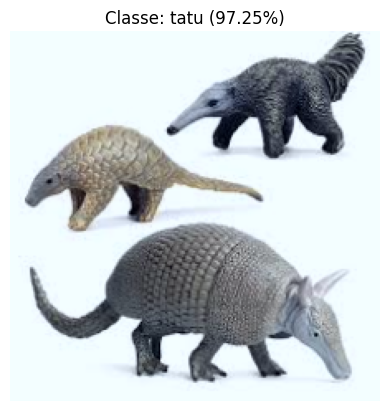

In [17]:
images, labels = next(iter(val_loader))

for image, label in zip(images, labels):
    plot_and_predict(model, image, val_set.classes)

## Exercícios

### Exercício 1
Treine novamente o modelo, mas sem data augmentation. Compare as curvas de treinamento de ambos os casos e comente.

100%|██████████| 13/13 [00:41<00:00,  3.21s/it]


Epoch 1, Train Loss: 0.174, Train Accuracy: 95.75%
Epoch 1, Val Loss: 0.165, Val Accuracy: 95.08%


100%|██████████| 13/13 [00:41<00:00,  3.17s/it]


Epoch 2, Train Loss: 0.154, Train Accuracy: 95.25%
Epoch 2, Val Loss: 0.141, Val Accuracy: 95.08%


100%|██████████| 13/13 [00:41<00:00,  3.16s/it]


Epoch 3, Train Loss: 0.154, Train Accuracy: 95.50%
Epoch 3, Val Loss: 0.164, Val Accuracy: 93.44%


100%|██████████| 13/13 [00:41<00:00,  3.18s/it]


Epoch 4, Train Loss: 0.153, Train Accuracy: 95.25%
Epoch 4, Val Loss: 0.135, Val Accuracy: 95.08%


100%|██████████| 13/13 [00:41<00:00,  3.17s/it]


Epoch 5, Train Loss: 0.140, Train Accuracy: 95.75%
Epoch 5, Val Loss: 0.133, Val Accuracy: 95.08%
Treinamento concluído


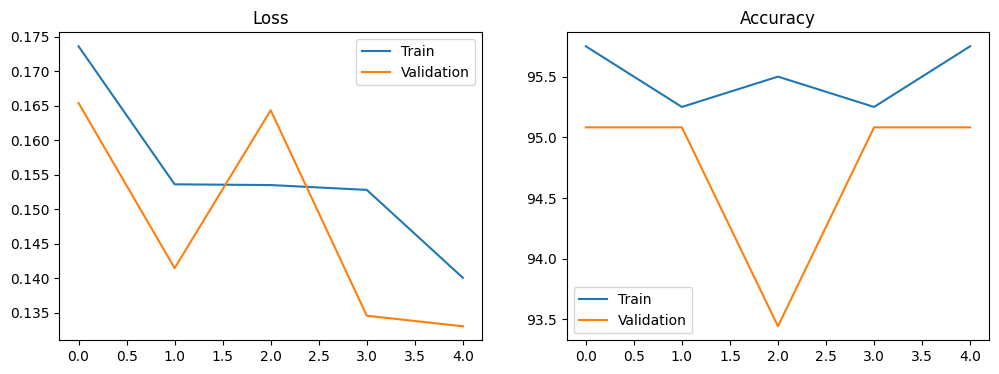

In [18]:
# Carregando os datasets sem data augmentation
train_set_no_aug = datasets.ImageFolder(os.path.join(data_dir, 'train'), transform=transform_no_aug)
train_loader_no_aug = DataLoader(train_set_no_aug, batch_size=32, shuffle=True)

# Treinando a CNN sem data augmentation
history_no_aug = train_model(model, train_loader_no_aug, val_loader, criterion, optimizer, device, num_epochs=5)
plot_history(history_no_aug)


### Exercício 2
Descongele mais das últimas camadas (à sua escolha), por exemplo `model.layer4[1]`, e treine novamente o modelo.

100%|██████████| 13/13 [00:46<00:00,  3.56s/it]


Epoch 1, Train Loss: 0.223, Train Accuracy: 92.25%
Epoch 1, Val Loss: 0.118, Val Accuracy: 95.08%


100%|██████████| 13/13 [00:45<00:00,  3.52s/it]


Epoch 2, Train Loss: 0.243, Train Accuracy: 89.50%
Epoch 2, Val Loss: 0.125, Val Accuracy: 95.08%


100%|██████████| 13/13 [00:45<00:00,  3.51s/it]


Epoch 3, Train Loss: 0.171, Train Accuracy: 92.50%
Epoch 3, Val Loss: 0.123, Val Accuracy: 95.08%


100%|██████████| 13/13 [00:45<00:00,  3.51s/it]


Epoch 4, Train Loss: 0.203, Train Accuracy: 92.25%
Epoch 4, Val Loss: 0.116, Val Accuracy: 94.26%


100%|██████████| 13/13 [00:45<00:00,  3.52s/it]


Epoch 5, Train Loss: 0.174, Train Accuracy: 93.50%
Epoch 5, Val Loss: 0.112, Val Accuracy: 95.08%
Treinamento concluído


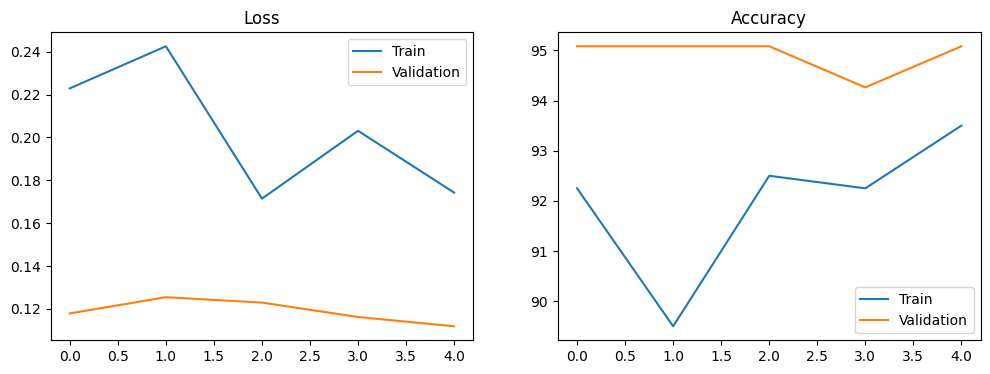

In [19]:
# Descongelar a camada layer4[1]
for param in model.layer4[1].parameters():
    param.requires_grad = True

# Treinando a CNN após descongelar camadas
history_unfreeze = train_model(model, train_loader, val_loader, criterion, optimizer, device, num_epochs=5)
plot_history(history_unfreeze)


### Exercício 3
Escolha outro modelo pré-treinado dos que foram vistos na aula e substitua no modelo. Lembre-se de alterar a última camada de classificação.

Downloading: "https://download.pytorch.org/models/mobilenet_v2-b0353104.pth" to /root/.cache/torch/hub/checkpoints/mobilenet_v2-b0353104.pth
100%|██████████| 13.6M/13.6M [00:00<00:00, 182MB/s]
100%|██████████| 13/13 [01:19<00:00,  6.10s/it]


Epoch 1, Train Loss: 0.773, Train Accuracy: 50.25%
Epoch 1, Val Loss: 0.757, Val Accuracy: 51.64%


100%|██████████| 13/13 [01:11<00:00,  5.52s/it]


Epoch 2, Train Loss: 0.791, Train Accuracy: 49.00%
Epoch 2, Val Loss: 0.761, Val Accuracy: 52.46%


100%|██████████| 13/13 [01:12<00:00,  5.58s/it]


Epoch 3, Train Loss: 0.768, Train Accuracy: 51.00%
Epoch 3, Val Loss: 0.759, Val Accuracy: 52.46%


100%|██████████| 13/13 [01:07<00:00,  5.20s/it]


Epoch 4, Train Loss: 0.795, Train Accuracy: 47.00%
Epoch 4, Val Loss: 0.768, Val Accuracy: 52.46%


100%|██████████| 13/13 [01:09<00:00,  5.37s/it]


Epoch 5, Train Loss: 0.772, Train Accuracy: 50.00%
Epoch 5, Val Loss: 0.767, Val Accuracy: 52.46%
Treinamento concluído


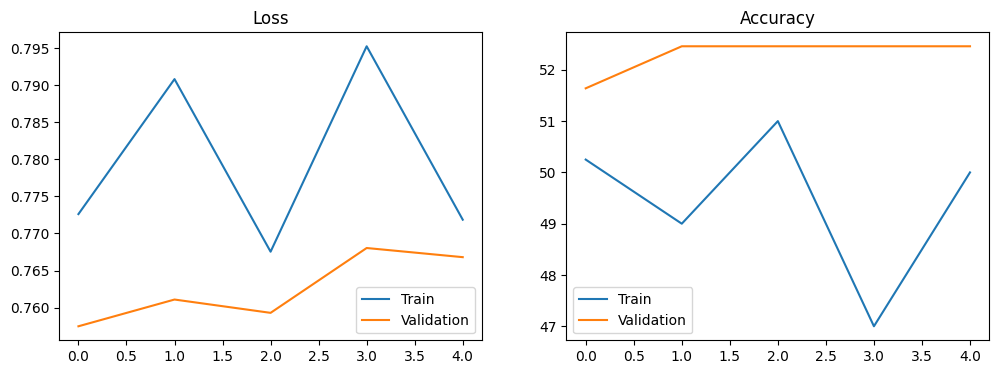

Acurácia da rede na base de teste: 52.46%


In [20]:
# Carregando o modelo MobileNet_V2 pré-treinado e treinando o modelo MobileNet_V2
model_mobilenet = models.mobilenet_v2(weights=MobileNet_V2_Weights.IMAGENET1K_V1)
model_mobilenet.classifier[1] = nn.Linear(model_mobilenet.classifier[1].in_features, 2)

model_mobilenet = model_mobilenet.to(device)

history_mobilenet = train_model(model_mobilenet, train_loader, val_loader, criterion, optimizer, device, num_epochs=5)
plot_history(history_mobilenet)
test_model(model_mobilenet, val_loader)
